In [128]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt# Made in collaboration with Rayan Afzal, Etienne Sasenarine, and Aliyah Amin

In [129]:
#load North Dakota COVID-19 dataset
df = pd.read_csv('North Dakota Covid Cases per day - Sheet1 (1).csv')

In [130]:
def centralCensor(data):
    """
    Central censors the data by computing weekly averages to simplify analysis and comparison.
    
    This function divides the input sequence of data into weekly intervals and calculates the 
    average for each interval. This converts the data from daily averages of cases of COVID-19
    reported to the average daily average of cases of COVID-19 reported for that week. This 
    process helps handle large data and produces smoother SIR graphical results which yields
    more accurate results.
    
    Parameter data: The input sequence of numerical data.
    Type data: list of float or int

    Return: A list containing the weekly averages of the input data.
    Type: list of float
    """
    count = 1
    weekList = []
    sumList = []
    while count - 1 < len(data):
        weekList.append(data[count - 1])
        if count % 7 == 0:
            sumList.append(sum(weekList))
            weekList.clear()
        count += 1
    for x in range(len(sumList)):
        sumList[x] = sumList[x] / 7
    return sumList

In [131]:
#constant beta of 1 / number of days infectious (20)
b = 0.05
#constant for time interval in days
t = 120
#constant for the population as a percent and also represents initial susceptible population
population = 1
#constant for inital recovered population (initially 0)
initialRecovered = 0
#constant for initial infected population (reported from March 19th, 2020)
initialInfected = 19 / 765309

#creates the list of real susceptible, infectious and recovered populations for each day along
#the 120 day time interval
realSusceptibles = []
realInfectious = centralCensor(df['Proportions'])
realRecovered = [0]
for x in range(17):
    realSusceptibles.append(population - df['Proportions'])
    realRecovered.append(realRecovered[x] + (b * realInfectious[x]))
dfReal = pd.DataFrame(list(zip(realSusceptibles, realInfectious, realRecovered)), columns = ['S', 'I', 'R'])

In [132]:
def equations(iS, iI, iR, a, b, t):
    """
    Simulates the SIR model over time using the SIR model equations.

    Calculates the progression of the SIR model through iteratively updating the
    proportions of the populations of Suceptible, Infectious and Recovered
    individuals over the 120 day interval based on the SIR model equations. 

    Parameter iS: The proportion of the initial susceptible population.
    Type iS: float or int

    Parameter iI: The proportion of the initial infected population.
    Type iI: float or int

    Parameter iR: The proportion of the initial recovered population.
    Type iR: float or int

    Parameter a: The force of infection (rate of disease transmission).
    Type a: float

    Parameter b: The recovery rate.
    Type b: float

    Parameter t: The number of weeks.
    Type t: int

    Return: A pandas DataFrame containing the populations of S, I, and R for each day.
    Columns: ['S', 'I', 'R']
    Type: pandas.DataFrame
    """
    S = [iS]
    I = [iI]
    R = [iR]
    for x in range(t + 1):
        S.append(S[x] - (a * S[x] * I[x]))
        I.append(I[x] + (a * S[x] * I[x]) - (b * I[x]))
        R.append(R[x] + (b * I[x]))
    dfModel = pd.DataFrame(list(zip(S, I, R)), columns = ['S', 'I', 'R'])
    return dfModel

In [133]:
def rssFinder(realI, modelI, t):
    """
    Calculates the Residual Sum of Squares (RSS) between real and model data.

    This function computes the RSS by summing the squared differences between the real 
    and model-predicted values over t number of days. If an `IndexError` occurs due to lists
    having different lengths, the function ignores it.

    Parameter realI: The sequence of real observed values.
    Type realI: list of float or int

    Parameter modelI: The sequence of predicted model values.
    Type modelI: list of float or int

    Parameter t: The number of weeks.
    Type t: int

    Return: The RSS value.
    Type: float
    """
    list = []
    for x in range(t):
        try:
            list.append((realI[x] - modelI[x]) ** 2)
        except IndexError:
            #Ignoring error
            a = 0
    return sum(list)

In [134]:
def optimizer(iS, iI, iR, t, realI, b = 0.05):
    """ 
    Finds the optimal alpha (transmission rate) value for the SIR model by minimizing the RSS.

    This function iteratively tests different alpha values from 0.001 to 1.0 to identify 
    the one that results in the minimum Residual Sum of Squares (RSS) between the real 
    observed data and the model-predicted data.

    Parameter iS: The proportion of the initial susceptible population.
    Type iS: float or int

    Parameter iI: The proportion of the initial infected population.
    Type iI: float or int

    Parameter iR: The proportion of the initial recovered population.
    Type iR: float or int

    Parameter t: The number of weeks.
    Type t: int

    Parameter realI: The sequence of real observed infectious counts.
    Type realI: list of float or int

    Parameter b: The recovery rate. 
    Type b: float (default is 0.05)

    Return: The optimal alpha value that minimizes the RSS.
    Type: float
    """
    a = 0.001
    rssValues = []
    dfModel = pd.DataFrame()
    realI = centralCensor(realI)
    modelI = []
    while a <= 1:
        dfModel = equations(iS, iI, iR, a, b, t)
        modelI = centralCensor(dfModel['I'])
        rssValues.append(rssFinder(realI, modelI, len(modelI)))
        a += 0.001
    minA = rssValues.index(min(rssValues)) / 1000
    return minA

In [135]:
def splitDate(list, date):
    """ 
    Splits a list of dates into two parts based on a given date index.

    This function divides a list of dates into two separate lists: one containing 
    a list of dates before the specified date index and the other containing a 
    list of dates from the specified date index onwards.

    Parameter list: The input list of dates to be split.
    Type list: list

    Parameter date: The date at which to split the list.
    Type date: int

    Return: A tuple of two lists:
        - The first list contains dates before the specified date index.
        - The second list contains dates from the specified date index onwards.
    Type: tuple of two lists
    """
    beforesplit = []
    aftersplit = []
    for i in range(len((list))):
        if i >= date:
            aftersplit.append(list[i])
        else:
            beforesplit.append(list[i])
    return beforesplit, aftersplit

In [136]:
def splitSIR(iS, iI, iR, t1, a1, t2 = -1, a2 = 0, t3 = -1, a3 = 0, b = 0.05):
    """ 
    Runs the SIR model equations with different transmission rates over split dates.

    This function calculates the progression of a Susceptible-Infectious-Recovered (SIR) 
    model over up to three time periods, each with its own transmission rate (alpha) 
    depending on the enacted health policy.

    Parameter iS: The proportion of the initial susceptible population.
    Type iS: float or int

    Parameter iI: The proportion of the initial infected population.
    Type iI: float or int

    Parameter iR: The proportion of the initial recovered population.
    Type iR: float or int

    Parameter t1: The first time interval.
    Type t1: int

    Parameter a1: The transmission rate for the first time interval.
    Type a1: float

    Parameter t2: The second time interval (optional).
    Type t2: int (default is -1)

    Parameter a2: The transmission rate for the second time interval (optional).
    Type a2: float (default is 0)

    Parameter t3: The third time interval (optional).
    Type t3: int (default is -1)

    Parameter a3: The transmission rate for the third time interval (optional).
    Type a3: float (default is 0)

    Parameter b: The recovery rate.
    Type b: float (default is 0.05)

    Return: A list containing the number of infectious individuals for each day.
    Type: list of float
    """
    S = [iS]
    I = [iI]
    R = [iR]
    for x in range(t1):
        S.append(S[x] - (a1 * S[x] * I[x]))
        I.append(I[x] + (a1 * S[x] * I[x]) - (b * I[x]))
        R.append(R[x] + (b * I[x]))
    if t2 != -1:
        for x in range(t1, t2):
            S.append(S[x] - (a2 * S[x] * I[x]))
            I.append(I[x] + (a2 * S[x] * I[x]) - (b * I[x]))
            R.append(R[x] + (b * I[x]))            
    if t3 != -1:   
        for x in range(t2, t3):
            S.append(S[x] - (a3 * S[x] * I[x]))
            I.append(I[x] + (a3 * S[x] * I[x]) - (b * I[x]))
            R.append(R[x] + (b * I[x]))  
    return I

In [137]:
def splitOptimizer(iS, iI, iR, t, realI, t1, t2 = -1, t3 = -1, b = 0.05):
    """
    Finds the optimal alpha values for the SIR model over split dates

    This function iteratively tests different alpha values from 0.001 
    to 1.0 for up to three time periods to identify the one that results 
    in the minimum Residual Sum of Squares (RSS) between the real observed 
    data and the model-predicted data.

    Parameter iS: The proportion of the initial susceptible population.
    Type iS: float or int

    Parameter iI: The proportion of the initial infected population.
    Type iI: float or int

    Parameter iR: The proportion of the initial recovered population.
    Type iR: float or int

    Parameter t: The number of weeks.
    Type t: int

    Parameter realI: The sequence of real observed infectious counts.
    Type realI: list of float or int

    Parameter t1: The first time interval.
    Type t1: int

    Parameter t2: The second time interval (optional).
    Type t2: int (default is -1)

    Parameter t3: The third time interval (optional).
    Type t3: int (default is -1)

    Parameter b: The recovery rate. 
    Type b: float (default is 0.05)

    Return: A tuple containing:
        - A list of optimal transmission rates for each time period.
        - The minimum RSS value achieved.
    Type: (list of float, float)
    """
    a1 = 0.01
    a2 = 0.01
    a3 = 0.01
    dfModel = pd.DataFrame()
    modelI = centralCensor(splitSIR(population, initialInfected, 0, t1, 0, t2, 0, t3, 0))
    min = rssFinder(realI, modelI, t)
    saveA1 = -1
    saveA2 = -1
    saveA3 = -1
    for x in range(0, 100):
        a1 = x/100
        if t2 != -1:
            for y in range(0, 100):
                a2 = y/100
                if t3 != -1:
                    for z in range(0, 100):
                        a3 = z/100
                        modelI = centralCensor(splitSIR(population, initialInfected, 0, t1, a1, t2, a2, t3, a3))
                        rss = rssFinder(realI, modelI, t)
                        if rss < min:
                            min = rss
                            saveA1 = a1 
                            saveA2 = a2 
                            saveA3 = a3
                else:
                    modelI = centralCensor(splitSIR(population, initialInfected, 0, t1, a1, t2, a2))
                    rss = rssFinder(realI, modelI, t)
                    if rss < min:
                        min = rss
                        saveA1 = a1 
                        saveA2 = a2 
        else:
            modelI = centralCensor(splitSIR(population, initialInfected, 0, t1, a1))
            rss = rssFinder(realI, modelI, t)
            if rss < min:
                    min = rss
                    saveA1 = a1
    aValues = [saveA1]
    if saveA2 != -1:
        aValues.append(saveA2)
    if saveA3 != -1:
        aValues.append(saveA3)
    return aValues, min                            

In [138]:
def computeAIC(aValues, rss, n):
    """
    Computes the Akaike Information Criterion (AIC) score for the model.

    The AIC score is computed using the formula AIC = N * Ln(MSE) + 2K.
    Lower AIC scores yield a better fit for the real data.

    Parameter aValues: The list of transmission rates.
    Type aValues: list of float

    Parameter rss: The rss between the model and real data.
    Type rss: float

    Parameter n: The number of data points.
    Type n: int

    Return: The AIC score for the model.
    Type: float
    """
    k = len(aValues)
    mse = rss / n
    ln = np.log(mse)
    AIC = n  * ln + 2 * k
    return AIC

In [139]:
def graphAIC(color, iS, iI, iR, realI, t1, t2 = -1, t3 = -1, t = 17):
    """
    Creates a graph of the infectious population over time for an SIR model.

    This function calculates the optimal transmission rates for specified time intervals, 
    computes the Akaike Information Criterion (AIC) score for the model and plots the infectious 
    population over time based on the computed parameters.

    Parameter color: The color of the graph plot.
    Type color: str

    Parameter iS: The proportion of the initial susceptible population.
    Type iS: float

    Parameter iI: The proportion of the initial infected population.
    Type iI: float

    Parameter iR: The proportion of the initial recovered population.
    Type iR: float

    Parameter realI: The sequence of real observed infectious counts.
    Type realI: list of float or int

    Parameter t1: The first time interval.
    Type t1: int

    Parameter t2: The second time interval (optional).
    Type t2: int (default is -1)

    Parameter t3: The third time interval (optional).
    Type t3: int (default is -1)

    Parameter t: The number of weeks.
    Type t: int (default is 17)

    Return: A plot of the infectious population for the specified model.
    Type: matplotlib plot object
    """
    if t2 != -1:
        if t3 != -1:
            dates = [t1, t2, t3]
            aValues, rss = splitOptimizer(iS, iI, iR, t, realI, t1, t2, t3)
            AIC = computeAIC(aValues, rss, t)
            print(str(dates) + ' ' + str(aValues) + ' ' + str(AIC) + ' in ' + color)
            return plt.plot(centralCensor(splitSIR(iS, iI, iR, t1, aValues[0], t2, aValues[1], t3, aValues[2])), color = color)
        else:
            dates = [t1, t2]
            aValues, rss = splitOptimizer(iS, iI, iR, t, realI, t1, t2)
            AIC = computeAIC(aValues, rss, t)
            print(str(dates) + ' ' + str(aValues) + ' ' + str(AIC) + ' in ' + color)
            return plt.plot(centralCensor(splitSIR(iS, iI, iR, t1, aValues[0], t2, aValues[1])), color = color)
    else:
        dates = [t1]
        aValues, rss = splitOptimizer(iS, iI, iR, t, realI, t1)
        AIC = computeAIC(aValues, rss, t)
        print(str(dates) + ' ' + str(aValues) + ' ' + str(AIC) + ' in ' + color)
        return plt.plot(centralCensor(splitSIR(iS, iI, iR, t1, aValues[0])), color = color)

[42, 64, 120] [0.14, 0.07, 0.04] -290.3249100773184 in Red
[8, 42, 120] [0.26, 0.12, 0.05] -290.4597645999022 in Blue
[8, 64, 120] [0.4, 0.08, 0.04] -287.69635591778695 in Green
[8, 120] [0.5, 0.06] -269.2089588195404 in Yellow
[42, 120] [0.15, 0.04] -281.33360010294723 in Orange
[64, 120] [0.12, 0.03] -270.11373051489846 in Purple
[120] [0.09] -245.9078108177268 in Pink


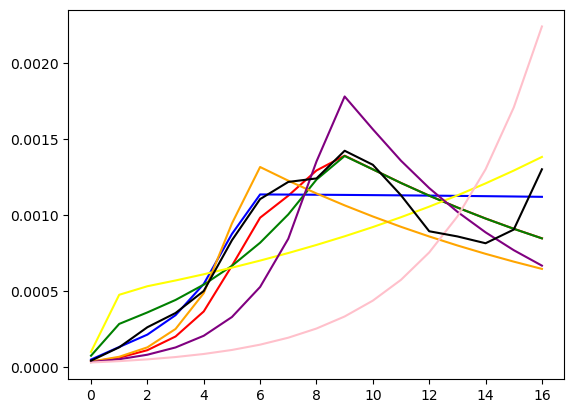

In [141]:
#SIR model with policies of reopening of buildings and North Dakota's "Smart Restart"
graphAIC('Red', population, initialInfected, initialRecovered, realInfectious, 42, 64, 120)
#SIR model with policies of business closure and reopening of buildings
graphAIC('Blue', population, initialInfected, initialRecovered, realInfectious, 8, 42, 120)
#SIR model with policies of business closure and North Dakota's "Smart Restart"
graphAIC('Green', population, initialInfected, initialRecovered, realInfectious, 8, 64, 120)
#SIR model with policy of business closure
graphAIC('Yellow', population, initialInfected, initialRecovered, realInfectious, 8, 120)
#SIR model with policy of reopening of buildings
graphAIC('Orange', population, initialInfected, initialRecovered, realInfectious, 42, 120)
#SIR model with policy of North Dakota's "Smart Restart"
graphAIC('Purple', population, initialInfected, initialRecovered, realInfectious, 64, 120)
#SIR model with no policy enacted
graphAIC('Pink', population, initialInfected, initialRecovered, realInfectious, 120)
#SIR model of real data
plt.plot(realInfectious, color = 'Black')